# Isolation Forest Analysis

In this workbook we aim to determine the contamination level we should use for our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import gzip
import shutil
import datetime
import networkx as nx
import pickle
import pyclustering
from scipy import stats
import seaborn as sns
import bz2
import json
import random
random.seed(1134)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from IPython.display import clear_output

#### KDD

For this analysis, we drop the Smurf and neptune attacks since they compromise such a vast majority of the data it would poorly impact the analysis.

In [2]:
kdd_data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz', compression='gzip', header=None)

In [3]:
kdd_data = kdd_data[(kdd_data[41] != 'neptune.')]
kdd_data = kdd_data[(kdd_data[41] != 'smurf.')]

In [4]:
kdd_data

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


In [5]:
kdd_att = {}
for e,val in enumerate(kdd_data[41].unique()):
    if val == 'normal.':
        kdd_att[val] = 1
    else:
        kdd_att[val] = -1
kdd_data[41] = kdd_data[41].map(kdd_att)

In [6]:
kdd_data_dum = pd.get_dummies(kdd_data)

In [7]:
kdd_X = kdd_data_dum.drop(41, axis=1)
kdd_Y = kdd_data_dum[41]

In [8]:
print('Attacks constitue {} % of the KDD-99 data.'.format((1 - ((kdd_data[41] == 1).sum() / len(kdd_data)))*100))

Attacks constitue 4.491481824751009 % of the KDD-99 data.


#### CIC

In [9]:
fri_ddos = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

fri_ps = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")

fri_mor = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Friday-WorkingHours-Morning.pcap_ISCX.csv")

thu_inf = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")

thu_wa = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")

wed = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Wednesday-workingHours.pcap_ISCX.csv")

tue = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Tuesday-WorkingHours.pcap_ISCX.csv")

mon = pd.read_csv(r"C:\Users\corri\OneDrive\Documents\Uni\Postgraduate\Final Project\CIC\Monday-WorkingHours.pcap_ISCX.csv")
frames = [mon, tue, wed, thu_wa, thu_inf, fri_mor, fri_ps, fri_ddos]
cic_df = pd.concat(frames)

In [10]:
cic_df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [11]:
cic_att = {}
for e,val in enumerate(cic_df[' Label'].unique()):
    if val == 'BENIGN':
        cic_att[val] = 1
    else:
        cic_att[val] = -1
cic_df[' Label'] = cic_df[' Label'].map(cic_att)

In [12]:
cic_df = cic_df.drop(['Flow Bytes/s', ' Flow Packets/s'],axis=1)

In [13]:
cic_X = cic_df.drop(' Label',axis=1)
cic_Y = cic_df[' Label']

In [14]:
print('Attacks constitue {} % of our CIC data.'.format((1-(cic_df[' Label'] == 1).sum()/len(cic_df))*100))

Attacks constitue 19.699633629757273 % of our CIC data.


#### UNSW

In [15]:
unsw_1 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS1.zip",header=None)
unsw_2 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS2.zip",header=None)
unsw_3 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS3.zip",header=None)
unsw_4 = pd.read_csv("https://github.com/Galeforse/DST-Assessment-04/raw/main/Data/UNS4.zip",header=None)
unsw_frames = [unsw_1,unsw_2,unsw_3,unsw_4]
unsw_df = pd.concat(unsw_frames)
colnames = (['source_ip', 'source_port', 'dest_ip', 'dest_port', 'proto', 'state', 'duration', 'source_bytes', 'dest_bytes', 'source_ttl',
             'dest_ttl', 'source_loss', 'dest_loss', 'service', 'source_load', 'dest_load', 'source_pkts', 'dest_pkts', 'source_TP_win', 'dest_TP_win', 
             'source_tcp_bn', 'dest_tcp_bn', 'source_mean_sz', 'dest_mean_sz', 'trans_depth', 'res_bdy_len', 'source_jitter', 'dest_jitter', 'start_time',
             'last_time', 'source_int_pk_time', 'dest_int_pk_time', 'tcp_rtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'count_state_ttl', 
             'count_flw_http_mthd', 'is_ftp_login', 'count_ftp_cmd', 'count_srv_source', 'count_srv_dest', 'count_dest_ltm',
             'count_source_ltm', 'count_source_destport_ltm', 'count_dest_sourceport_ltm', 'counts_dest_source_ltm', 'attack_cat', 'Label'])
unsw_df.columns = colnames

C:\Users\corri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\corri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
unsw_df

,source_ip,source_port,dest_ip,dest_port,proto,state,duration,source_bytes,dest_bytes,source_ttl,...,count_ftp_cmd,count_srv_source,count_srv_dest,count_dest_ltm,count_source_ltm,count_source_destport_ltm,count_dest_sourceport_ltm,counts_dest_source_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440039,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,...,,1,2,3,3,1,1,3,NaN,0
440040,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,NaN,0
440041,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,...,2,2,2,4,2,2,2,2,NaN,0
440042,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,...,,1,1,2,4,2,2,2,NaN,0


In [17]:
unsw_df = unsw_df.fillna(0)
unsw_df['count_ftp_cmd'] = unsw_df['count_ftp_cmd'].replace(' ',0)
unsw_df['attack_cat'] = unsw_df['attack_cat'].map({'Normal': 'Normal', 'Exploits': 'Exploits', ' Fuzzers ': 'Fuzzers', 'DoS': 'DoS',
                                          ' Reconnaissance ': 'Reconnaissance', ' Fuzzers': 'Fuzzers', 'Analysis': 'Analysis',
                                         'Backdoor': 'Backdoor', 'Reconnaissance': 'Reconnaissance',  ' Shellcode ': 'Shellcode',
                                         'Backdoors': 'Backdoor', 'Shellcode': 'Shellcode',  'Worms': 'Worms', 'Generic': 'Generic'})
df_source_ip = pd.DataFrame(unsw_df['source_ip'])
df_source_port = pd.DataFrame(unsw_df['source_port'])
df_dest_ip = pd.DataFrame(unsw_df['dest_ip'])
df_dest_port = pd.DataFrame(unsw_df['dest_port'])
df_proto = pd.DataFrame(unsw_df['proto'])
df_state = pd.DataFrame(unsw_df['state'])
df_service = pd.DataFrame(unsw_df['service'])
df_count_ftp_cmd = pd.DataFrame(unsw_df['count_ftp_cmd'])
df_attack_cat = pd.DataFrame(unsw_df['attack_cat'])

sips = unsw_df.source_ip.unique()
sip_dict = dict(zip(sips,range(len(sips))))

sp = unsw_df.source_port.unique()
sp_dict = dict(zip(sp,range(len(sp))))
               
dips = unsw_df.dest_ip.unique()
dip_dict = dict(zip(dips,range(len(dips))))

dp = unsw_df.dest_port.unique()
dp_dict = dict(zip(dp,range(len(dp))))

p = unsw_df.proto.unique()
p_dict = dict(zip(p,range(len(p))))

states = unsw_df.state.unique()
state_dict = dict(zip(states,range(len(states))))

services = unsw_df.service.unique()
service_dict = dict(zip(services,range(len(services))))

cfc = unsw_df.count_ftp_cmd.unique()
cfc_dict = dict(zip(cfc,range(len(cfc))))

unsw_df['source_ip_int'] = unsw_df['source_ip'].map(sip_dict)
unsw_df['source_port_int'] = unsw_df['source_port'].map(sp_dict)
unsw_df['dest_ip_int'] = unsw_df['dest_ip'].map(dip_dict)
unsw_df['dest_port_int'] = unsw_df['dest_port'].map(dp_dict)
unsw_df['proto_int'] = unsw_df['proto'].map(p_dict)
unsw_df['state_int'] = unsw_df['state'].map(state_dict)
unsw_df['service_int'] = unsw_df['service'].map(service_dict)
unsw_df['count_ftp_cmd_int'] = unsw_df['count_ftp_cmd'].map(cfc_dict)

unsw_df = unsw_df.drop('source_ip',axis=1)
unsw_df = unsw_df.drop('source_port',axis=1)
unsw_df = unsw_df.drop('dest_ip',axis=1)
unsw_df = unsw_df.drop('dest_port',axis=1)
unsw_df = unsw_df.drop('proto',axis=1)
unsw_df = unsw_df.drop('state',axis=1)
unsw_df = unsw_df.drop('service',axis=1)
unsw_df = unsw_df.drop('count_ftp_cmd',axis=1)
unsw_df = unsw_df.drop('attack_cat',axis=1)

unsw_df['Label'] = unsw_df['Label'].map({0: 1, 1: -1})

unsw_X = unsw_df.drop('Label', axis=1)
unsw_Y = unsw_df['Label']

In [18]:
print('Attacks constitue {} % of our UNSW data.'.format((1-(unsw_df['Label'] == 1).sum()/len(unsw_df))*100))

Attacks constitue 12.648702957071267 % of our UNSW data.


### Isolation Forest

In [27]:
def if_process(X,c):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled = scaler.transform(X)
    data = pd.DataFrame(scaled)
    
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    if_values = if_model.decision_function(data)
    return if_predictions, if_values

In [28]:
kdd_predictions, kdd_values = if_process(kdd_X,0.05)

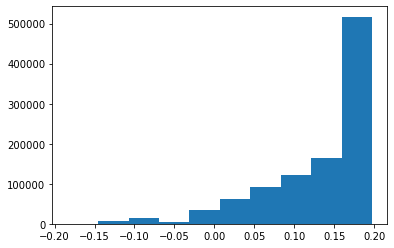

In [65]:
plt.figure()
plt.hist(kdd_values)
plt.show()

In [49]:
cic_predictions, cic_values = if_process(cic_X,0.2)

In [50]:
unsw_predictions, unsw_values = if_process(unsw_X,0.12)

In [99]:
def iqr_bounds(scores,k=1.5):
    q1 = np.percentile(scores,0.25)
    q3 = np.percentile(scores,0.75)
    iqr = q3 - q1
    lower_bound=(q1 - k * iqr)
    upper_bound=(q3 + k * iqr)
    print("Lower bound:{} \nUpper bound:{}".format(lower_bound,upper_bound))
    return lower_bound,upper_bound

lower_bound,upper_bound=iqr_bounds(kdd_values)

Lower bound:-0.16364741314916126 
Upper bound:-0.07385329481180986


In [100]:
len(np.where(kdd_predictions==-1)[0])

50925

### Analysis of Predictions

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score
import seaborn as sn

In [58]:
def classification_eval(predictions, actual):
    
    dec = np.int64(np.ceil(np.log10(len(actual))))
    
    print("Confusion Matrix")
    print(confusion_matrix(actual,predictions),'\n')
    
    print('Classification report')
    print(classification_report(actual, predictions, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(actual, predictions)))
    

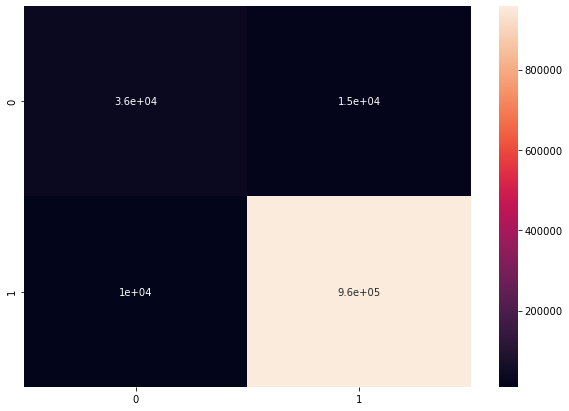

In [59]:
a = confusion_matrix(kdd_predictions, kdd_Y)
plt.figure(figsize = (10,7))
sn.heatmap(a, annot=True)
plt.show()

In [60]:
classification_eval(kdd_predictions,kdd_Y)

Confusion Matrix
[[ 35744  10003]
 [ 15181 957600]] 

Classification report
              precision    recall  f1-score   support

          -1  0.7018949 0.7813409 0.7394902     45747
           1  0.9896621 0.9843942 0.9870211    972781

    accuracy                      0.9752741   1018528
   macro avg  0.8457785 0.8828675 0.8632557   1018528
weighted avg  0.9767371 0.9752741 0.9759033   1018528

Scalar Metrics
          MCC = 0.7277015


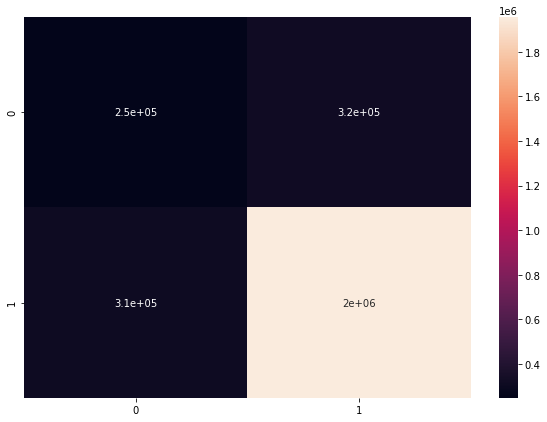

In [61]:
a = confusion_matrix(cic_predictions, cic_Y)
plt.figure(figsize = (10,7))
sn.heatmap(a, annot=True)
plt.show()

In [62]:
classification_eval(cic_predictions,cic_Y)

Confusion Matrix
[[ 247708  309938]
 [ 318437 1954660]] 

Classification report
              precision    recall  f1-score   support

          -1  0.4375346 0.4442030 0.4408435    557646
           1  0.8631377 0.8599105 0.8615211   2273097

    accuracy                      0.7780176   2830743
   macro avg  0.6503361 0.6520567 0.6511823   2830743
weighted avg  0.7792955 0.7780176 0.7786492   2830743

Scalar Metrics
          MCC = 0.3023880


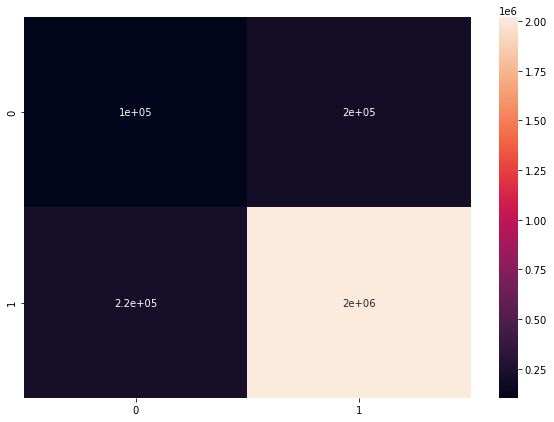

In [63]:
a = confusion_matrix(unsw_predictions, unsw_Y)
plt.figure(figsize = (10,7))
sn.heatmap(a, annot=True)
plt.show()

In [64]:
classification_eval(unsw_predictions,unsw_Y)

Confusion Matrix
[[ 104201  217082]
 [ 200418 2018346]] 

Classification report
              precision    recall  f1-score   support

          -1  0.3420699 0.3243278 0.3329627    321283
           1  0.9028902 0.9096713 0.9062681   2218764

    accuracy                      0.8356330   2540047
   macro avg  0.6224801 0.6169996 0.6196154   2540047
weighted avg  0.8319537 0.8356330 0.8337524   2540047

Scalar Metrics
          MCC = 0.2394169
